# CHILD ML Analysis
    - ML Pipeline for CHILD Dataset from the very beginning

##### Step One: Feature Selection Strategies (Insights)

##### Step Two: Making ML Pipelines

##### Step Three: Tunning & Feature Engineering/Selection (data review) to Improve Performance (Insights)

##### Step Four: Visualization of model performance

##### Step Five: Paper, Deployment

### Libraries

In [33]:
# Preferences of autoformatting & Multiple Output
%load_ext nb_black

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import warnings

warnings.filterwarnings("ignore")

import researchpy as rp  # For auto-statistics/EDA of dataframe
from tqdm.notebook import tqdm  # For process display
import importlib  # For viewing library structure (dependancies, etc)

import sys

sys.path.append("../src")

from data import *
from utils import *
from conf import *

import utils as UT
import data as DT

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

from sklearn.model_selection import cross_val_score

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

### Data

In [6]:
# df_raw = generate_raw_xlsx()
df_child = load_child_with_more()

Loading ('../data/addon/Prenatal Q91PRNMH18WK.xlsx', '../output/CHILD_raw.xlsx', '../data/addon/breastfeeding data.xlsx', '../data/addon/Prenatal Q91PRNMH18WK.xlsx'), and merging
The dataframe merged with more information is saved to ../output/ with name of CHILD_with_addon.xlsx


<IPython.core.display.Javascript object>

In [7]:
df_targeted = target_selector(df_child, target_mapping={2: np.nan})

The dimension of original dataframe for process is (3455, 157)
Number of categorical features is:  56
Number of numeric features is:  24
Number of target variables is:  13
Number of dropped features is:  63
The difference of features of targeted and original dataframe is :{'Subject_Number'}
The number of missing value for target label is: 809
------------------------------------------------------
Note: Target variable can be one of: 
 ['Asthma_Diagnosis_3yCLA', 'Asthma_Diagnosis_5yCLA', 'Recurrent_Wheeze_1y', 'Recurrent_Wheeze_3y', 'Recurrent_Wheeze_5y', 'Wheeze_Traj_Type', 'Medicine_for_Wheeze_5yCLA', 'Viral_Asthma_3yCLA', 'Triggered_Asthma_3yCLA', 'Viral_Asthma_5yCLA', 'Triggered_Asthma_5yCLA', 'Cumulative_Wheeze_36m', 'Cumulative_Wheeze_60m']
------------------------------------------------------
****Target variable will be renamed to y for easy access.**** 



<IPython.core.display.Javascript object>

In [8]:
df_shrunk, X, y, df_dropped = sample_selector(df_targeted)

A total of 15 / 165 (9.1%) for asthma positive are dropped due to more than 10 missing value in the sample.

The total number of dropped samples is 181


<IPython.core.display.Javascript object>

In [69]:
# Restore raw data
df = df_shrunk.copy()
X = df_shrunk.drop(columns="y").copy()
y = df_shrunk["y"].copy()

<IPython.core.display.Javascript object>

###  Test Run of Transformers

In [10]:
df_for_ml = generate_trainable_dataset(X, y, add_indicator_threshold=30)

The output columns will be: RIfrequency_earlier_report, RIseverity_earlier_report, RIfrequency_later_report, RIseverity_later_report
---------------------------------------------------------------------------------------------------
Given the correlation threshhold of 0.9, the columns that will be removed are:['Noncold_Wheeze_3m', 'Antibiotics_Usage', 'Dad_Inhalant', 'Mom_Inhalant']. Please see the following correlation:{'Antibiotics_Usage <> Number_of_AntibioticsCourse': 0.9415315843229445, 'Noncold_Wheeze_3m <> Epi_Noncold_Wheeze_3m': 0.9269937706805971, 'Dad_Inhalant <> Dad_Atopy': 1.0, 'Mom_Inhalant <> Mom_Atopy': 0.9981287992337443}
---------------------------------------------------------------------------------------------------
Given the correlation threshhold of 0.7, the columns that will be considered to be dropped are:['CSED_6m', 'Noncold_Wheeze_3m', 'Dad_Inhalant', 'CSED_36week', 'BF_12m', 'Antibiotics_Usage', 'First_10min_Measure', 'Mother_Condition_Delivery', 'Mom_Inhalan

<IPython.core.display.Javascript object>

In [66]:
# Backup df_for_ml
df_for_ml_backup = df_for_ml.copy()

<IPython.core.display.Javascript object>

In [256]:
df_for_ml.y.value_counts(normalize=True)
df_for_ml.y.value_counts(normalize=False)
# Restore X,y for ML modelling
X = df_for_ml.drop(columns="y")
y = df_for_ml.y
X.shape
y.shape

0.0    0.932372
1.0    0.067628
Name: y, dtype: float64

0.0    2068
1.0     150
Name: y, dtype: int64

(2218, 102)

(2218,)

<IPython.core.display.Javascript object>

In [390]:
# Scaled ML using MinMaxScaler()
df_ml_scaled = pd.DataFrame(
    MinMaxScaler().fit_transform(df_for_ml), columns=df_for_ml.columns
)

for i in df_ml_scaled.columns:
    df_ml_scaled[i] = df_ml_scaled[i].astype("float16")

X = df_ml_scaled.drop(columns="y")
y = df_ml_scaled.y
X.shape
y.shape

(2218, 102)

(2218,)

<IPython.core.display.Javascript object>

## Now begins the INTERESTING ML Journey!

In [599]:
def view_module_functions(module_alias):
    """
    Quick review of self-written functions and classes
    """
    return [
        i
        for i in dir(module_alias)
        if (not i.isupper()) & ~(i.startswith("_")) & (len(i) > 6)
    ]


print(view_module_functions(UT))
print(view_module_functions(DT))

['ApgarTransformer', 'BaseEstimator', 'BirthTransformer', 'CatNaNImputer', 'ColumnFilter', 'DiscretizePSS', 'ImputerStrategizer', 'KNNImputer', 'Log1pTransformer', 'MissForest', 'RespiratoryTransformer', 'SimpleImputer', 'TransformerMixin', 'generate_trainable_dataset', 'load_child_with_more', 'numeric_imputation', 'numeric_imputation_selector', 'sample_selector', 'sklearn', 'target_selector']
['data_mapping', 'data_repo_review', 'data_selection', 'dummy_reversed_features', 'feature_selection', 'generate_raw_xlsx']


<IPython.core.display.Javascript object>

In [597]:
# Summary of created dataframe for CHILD
def df_summary(X):
    """
    Overview the number of unique values, Top percentage of value distribution, for each feature 
    """

    cols_to_inspect = X.columns

    top_percentage = {}
    for i in X[cols_to_inspect].columns:
        top_percentage[i] = round(
            (X[i].value_counts(normalize=True).values[0] * 100), 2
        )
    per_ser = pd.Series(top_percentage)

    df_overview = (
        pd.concat(
            [
                X[cols_to_inspect].nunique(),
                X[cols_to_inspect].mean(),
                per_ser,
                X[cols_to_inspect].max(),
                X[cols_to_inspect].sum(),
                X[cols_to_inspect].var(),
            ],
            axis=1,
        )
        .rename(
            columns={
                0: "Num_Unique_Values",
                1: "Mean_Value",
                2: "Top_Percentage",
                3: "Max_Value",
                4: "Number_of_Binary_Positive",
                5: "Variance",
            }
        )
        .sort_values(by="Top_Percentage", ascending=False)
    )

    return df_overview


X_summary = df_summary(X)
X_summary.sort_values(by="Variance")

,Num_Unique_Values,Mean_Value,Top_Percentage,Max_Value,Number_of_Binary_Positive,Variance
Prenatal_Hypotension,2,0.001803,99.82,1.0,4.000000,0.001801
Apgar_Score_5min,8,0.938477,88.86,1.0,2082.000000,0.001957
Prenatal_Cardiac_Disorder,2,0.004059,99.59,1.0,9.000000,0.004044
Epi_Noncold_Wheeze_3m,16,0.013741,95.49,1.0,30.484375,0.005596
RIseverity_earlier_report,14,0.063660,36.70,1.0,141.250000,0.006081
...,...,...,...,...,...,...
PSS_12m_Low_Stress,2,0.544434,54.46,1.0,1208.000000,0.248047
PSS_18week_Low_Stress,2,0.532227,53.25,1.0,1181.000000,0.249023
Gender_M,2,0.531250,53.11,1.0,1178.000000,0.249268
BF_12m,2,0.475098,52.48,1.0,1054.000000,0.249390


<IPython.core.display.Javascript object>

In [598]:
def view_y_proportions(df, columns_of_interest, thresh=0):
    """
    Gadget to view the asthma proportions for different columns during feature selection
    """
    general_proportion = round((100 * df[df.y == 1].shape[0] / df.shape[0]), 2)
    print(
        "The proportion of definite asthma outcome for general cohorts is {}%".format(
            general_proportion
        )
    )
    asthma_for_col_number = []
    asthma_for_col_proportion = []
    col_with_thresh_number = []
    for i in columns_of_interest:

        total_of_subsamples = df[df[i] > thresh].shape[0]

        if 1 in df[df[i] > thresh].y.value_counts().sort_values(ascending=True).index:
            number_of_asthma = (
                df[df[i] > thresh].y.value_counts().sort_values(ascending=True).loc[1]
            )
        else:
            number_of_asthma = 0

        proportion = round(
            (number_of_asthma / (total_of_subsamples + 0.000001) * 100), 2
        )

        col_with_thresh_number.append(total_of_subsamples)
        asthma_for_col_proportion.append(proportion)
        asthma_for_col_number.append(number_of_asthma)
    #         print(
    #             "The proportion of asthma outcome when the value of {} is greater than {} is {}% or {} out of {}".format(
    #                 i, thresh, proportion, number_of_asthma, total_of_subsamples
    #             )
    #         )

    col_y_df = pd.DataFrame(
        [
            asthma_for_col_proportion,
            asthma_for_col_number,
            col_with_thresh_number,
            np.ones(len(col_with_thresh_number)) * thresh,
        ],
        index=[
            "Asthma_Proportion_over_thresh",
            "Asthma_Outcome_over_thresh",
            "Total_Number_over_thresh",
            "Thresh",
        ],
        columns=columns_of_interest,
    )

    general_ser = pd.Series(
        [general_proportion, df[df.y == 1].shape[0], df.shape[0], 0],
        name="GENERAL",
        index=[
            "Asthma_Proportion_over_thresh",
            "Asthma_Outcome_over_thresh",
            "Total_Number_over_thresh",
            "Thresh",
        ],
    )

    return col_y_df.T.append(general_ser).sort_values(
        by="Asthma_Proportion_over_thresh", ascending=False
    )


view_y_proportions(df_ml_scaled, df_ml_scaled.columns[:-1], 0.6)[
    view_y_proportions(df_ml_scaled, df_ml_scaled.columns[:-1], 0.6)[
        "Asthma_Proportion_over_thresh"
    ]
    > 7.0
][:5]

The proportion of definite asthma outcome for general cohorts is 6.76%
The proportion of definite asthma outcome for general cohorts is 6.76%


,Asthma_Proportion_over_thresh,Asthma_Outcome_over_thresh,Total_Number_over_thresh,Thresh
Epi_Noncold_Wheeze_3m,42.86,3.0,7.0,0.6
RIseverity_later_report,40.91,9.0,22.0,0.6
RIseverity_earlier_report,33.33,1.0,3.0,0.6
Number_of_AntibioticsCourse,29.73,11.0,37.0,0.6
RIfrequency_earlier_report,18.75,3.0,16.0,0.6


<IPython.core.display.Javascript object>

### ML Libraries

In [595]:
# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Feature selection
from sklearn.feature_selection import (
    SelectPercentile,
    chi2,
    mutual_info_classif,
    SelectFromModel,
    f_classif,
    SequentialFeatureSelector,
    RFECV,
)
from sklearn.inspection import permutation_importance

# Imbalance Learn
from imblearn.over_sampling import RandomOverSampler

# Models
from sklearn.linear_model import LogisticRegression, Lasso, LassoLarsCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Ensemble
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Model Metrics, Parameters, Evaluation
from sklearn.model_selection import (
    StratifiedKFold,
    GridSearchCV,
    cross_val_score,
    train_test_split,
)


from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    roc_curve,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)

# Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

<IPython.core.display.Javascript object>

### Feature Selection

1. [Lasso](#lasso)
2. [Chi2](#chi2)
3. [f_value](#f_classif)
4. [FalsePositiveRate](#fpr)
5. [p_value](#fwe)
6. [mutual_information](#mutal)
7. [Recursive Feature Elimination](#RFE)
8. [SelectFromModel](#selm)
9. [permutation_importance](#permutation)
10. [SequentialFeatureSelector](#sequentialgreed)

### Feature Engineering
1. [PCA](#pca)
2. [FeatureAgglomeration](#clusteragglomeration)
3. [Derived_New_Features_with_Expertise_Logic](#derivenewfeature)

#### (1) Lasso - Observation - 1

In [380]:
# Automatic Alphas with StratifiedKfold
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=1015)
model = LassoLarsCV(cv=skf).fit(X, y)

<IPython.core.display.Javascript object>

(0.00015, 0.00085)

Text(0, 0.5, 'Lasso Regression CV')

Text(0.5, 0, 'Regularization Factor - Alphas')

Text(0.5, 1.0, 'Regression Coefficient Progression for Lasso Path')

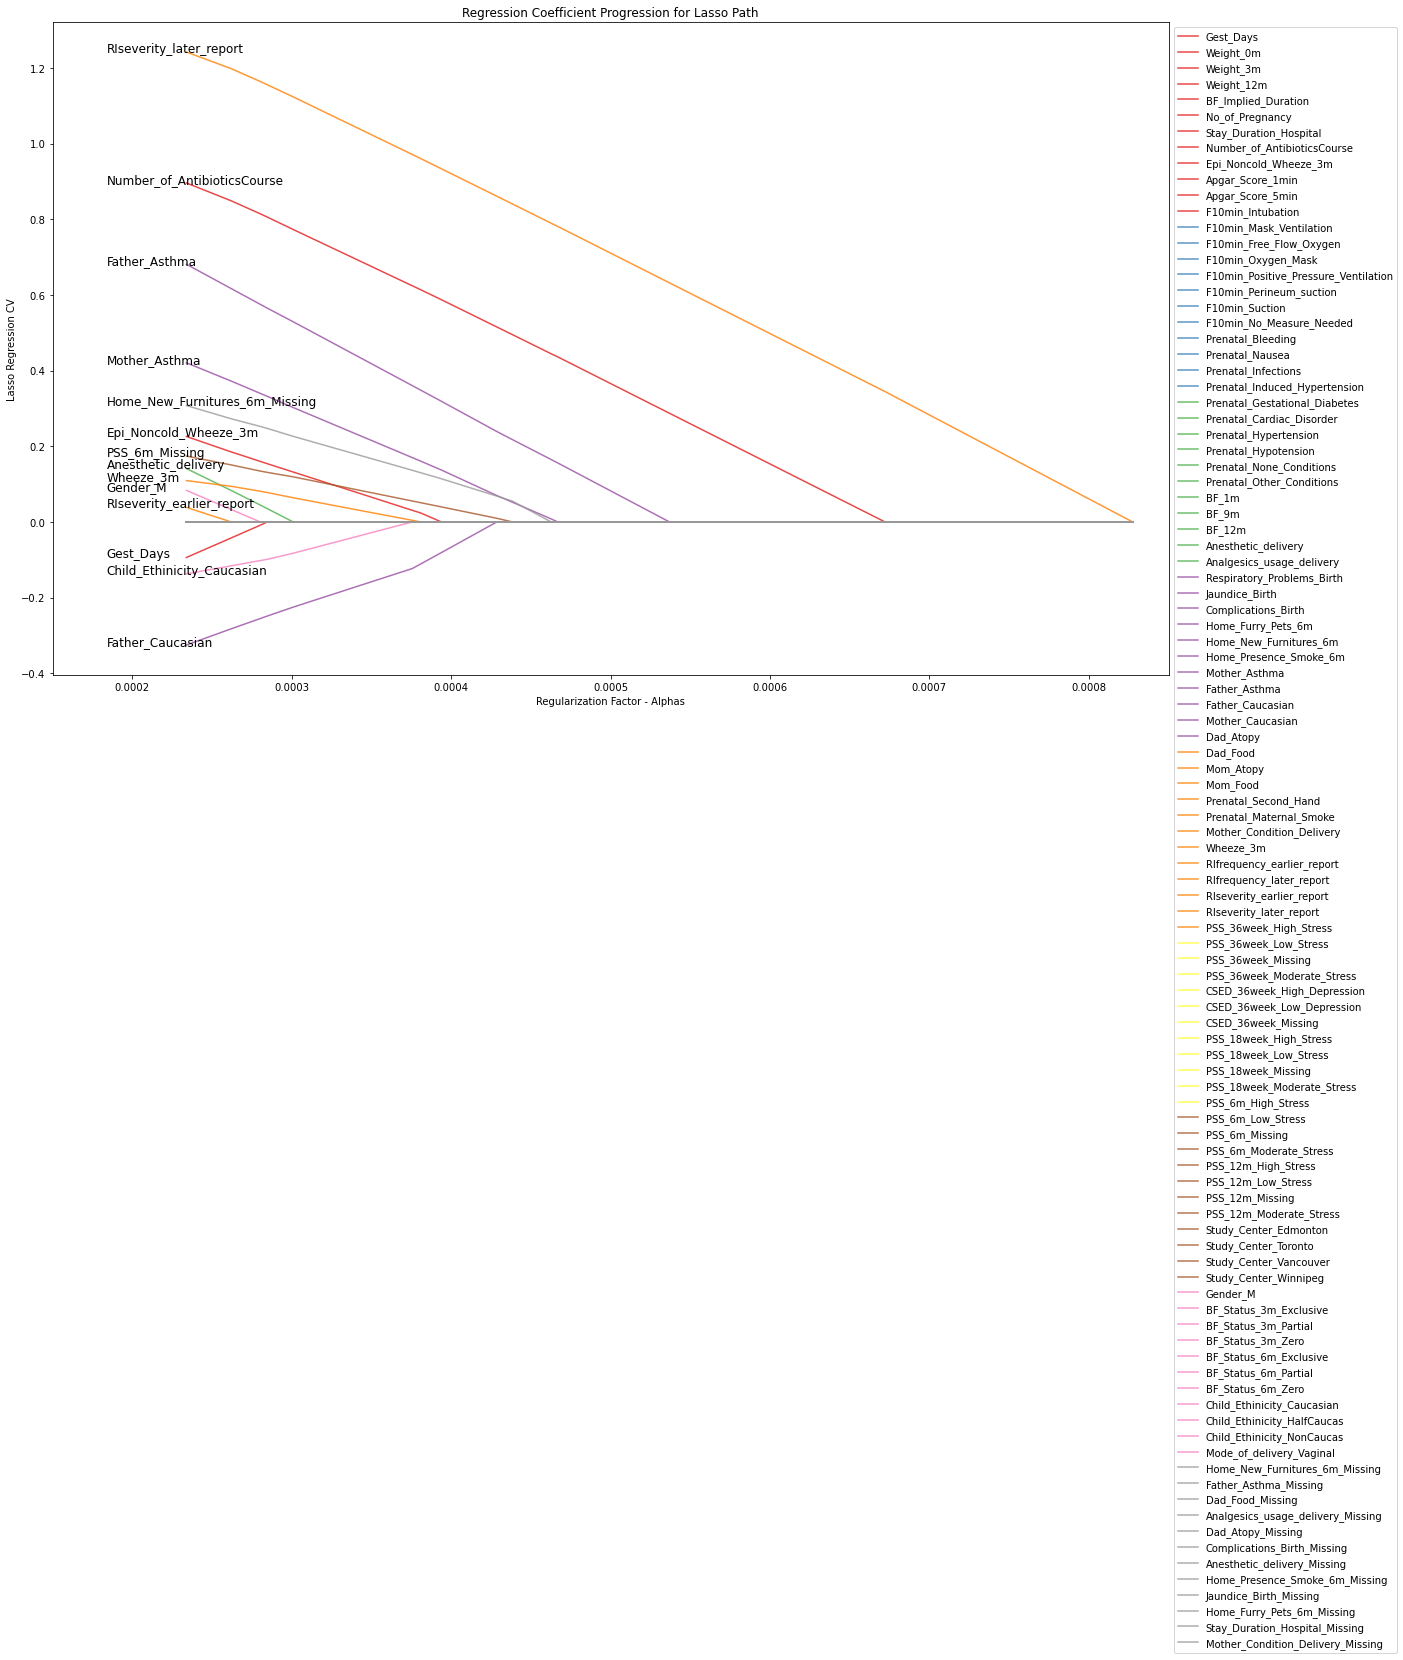

<IPython.core.display.Javascript object>

In [382]:
fig, ax = plt.subplots(figsize=(20, 12))
columns_of_total = X.shape[1]
start = 0
end = 102
number_of_display = end - start

cm = iter(plt.get_cmap("Set1")(np.linspace(0, 1, number_of_display)))
for i in range(start, end):
    c = next(cm)
    _ = ax.plot(
        model.alphas_, model.coef_path_.T[:, i], c=c, alpha=0.8, label=X.columns[i]
    )


lassocv_df = pd.DataFrame(
    data=model.coef_path_.T, columns=X.columns, index=model.alphas_
)

y_pos_ser = lassocv_df.iloc[-1:].T.iloc[:, 0][lassocv_df.iloc[-1:].T.iloc[:, 0] != 0]
x_pos = float(lassocv_df.iloc[-1:].T.columns.values)
x_pos_list = [x_pos for i in range(len(y_pos_ser))]

for x_t, y_t, text in zip(x_pos_list, y_pos_ser.values, y_pos_ser.index):
    axtxt = ax.text(
        x_t - 0.00005,
        y_t,
        text,  # Used to format it K representation
        color="black",
        rotation="horizontal",
        size="large",
    )

ax.legend(X.columns[start:end], bbox_to_anchor=(1, 1))

plt.xlim([0.00015, 0.00085])
plt.ylabel("Lasso Regression CV")
plt.xlabel("Regularization Factor - Alphas")
plt.title("Regression Coefficient Progression for Lasso Path")

fig.savefig("../images/lasso_progression",dpi=300,bbox_inches='tight')


In [369]:
view_y_proportions(
    df_for_ml, lassocv_df.sum()[lassocv_df.sum() != 0].sort_values().index, 0.5
)

The proportion of definite asthma outcome for general cohorts is 6.76%


,Asthma_Proportion_over_thresh,Asthma_Outcome_over_thresh,Total_Number_over_thresh,Thresh
RIseverity_later_report,30.00,24.0,80.0,0.5
Epi_Noncold_Wheeze_3m,16.42,11.0,67.0,0.5
RIseverity_earlier_report,14.29,6.0,42.0,0.5
Wheeze_3m,14.29,23.0,161.0,0.5
Home_New_Furnitures_6m_Missing,12.76,31.0,243.0,0.5
PSS_6m_Missing,12.65,32.0,253.0,0.5
Number_of_AntibioticsCourse,12.63,48.0,380.0,0.5
Father_Asthma,12.61,44.0,349.0,0.5
Mother_Asthma,11.40,52.0,456.0,0.5
Gender_M,8.23,97.0,1178.0,0.5


<IPython.core.display.Javascript object>

#### Lasso - Observation - 2 - All features decreasing pattern

In [467]:
coef_dict = {}
for alp in tqdm(np.arange(0.000001, 0.0009, 0.000005)):
    lasso_model = Lasso(alpha=alp).fit(X, y)
    coef_dict[alp] = list(lasso_model.coef_)

res = pd.DataFrame(data=coef_dict.values(), columns=X.columns, index=coef_dict.keys()).T

  0%|          | 0/180 [00:00<?, ?it/s]

,0.000001,0.000006,0.000011,0.000016,0.000021,0.000026,0.000031,0.000036,0.000041,0.000046,...,0.000851,0.000856,0.000861,0.000866,0.000871,0.000876,0.000881,0.000886,0.000891,0.000896
Home_Furry_Pets_6m_Missing,0.023744,0.015500,0.007257,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000045,0.000045,0.000046,0.000046,0.000046,0.000046,0.000046,0.000046,0.000046,0.000046
Stay_Duration_Hospital_Missing,-0.020753,-0.020527,-0.020301,-0.020076,-0.019913,-0.019750,-0.019586,-0.019418,-0.019248,-0.019086,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
Mother_Condition_Delivery_Missing,0.000923,0.000733,0.000551,0.000376,0.000449,0.000531,0.000614,0.000696,0.000779,0.000858,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<IPython.core.display.Javascript object>

In [535]:
# For those with bitter coefficient (impact)
res[0.000001][abs(res[0.000001]) > 0.05].sort_values().index
view_y_proportions

Index(['Mother_Condition_Delivery', 'RIfrequency_later_report', 'Gest_Days',
       'F10min_Oxygen_Mask', 'Prenatal_Hypotension', 'PSS_36week_Missing',
       'Prenatal_Other_Conditions', 'Father_Asthma', 'BF_Status_6m_Zero',
       'BF_Status_6m_Exclusive', 'BF_Status_6m_Partial',
       'Prenatal_Gestational_Diabetes', 'Prenatal_Cardiac_Disorder',
       'Epi_Noncold_Wheeze_3m', 'Apgar_Score_5min',
       'Number_of_AntibioticsCourse', 'RIseverity_later_report'],
      dtype='object')

<IPython.core.display.Javascript object>

In [533]:
res.iloc[:, -5:]

,0.000876,0.000881,0.000886,0.000891,0.000896
Gest_Days,-0.031266,-0.031043,-0.030821,-0.030599,-0.030377
Weight_0m,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
Weight_3m,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
Weight_12m,0.000000,0.000000,0.000000,0.000000,0.000000
BF_Implied_Duration,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
...,...,...,...,...,...
Home_Presence_Smoke_6m_Missing,0.000000,0.000000,0.000000,0.000000,0.000000
Jaundice_Birth_Missing,0.000000,0.000000,0.000000,0.000000,0.000000
Home_Furry_Pets_6m_Missing,0.000046,0.000046,0.000046,0.000046,0.000046
Stay_Duration_Hospital_Missing,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000


<IPython.core.display.Javascript object>

<AxesSubplot:>

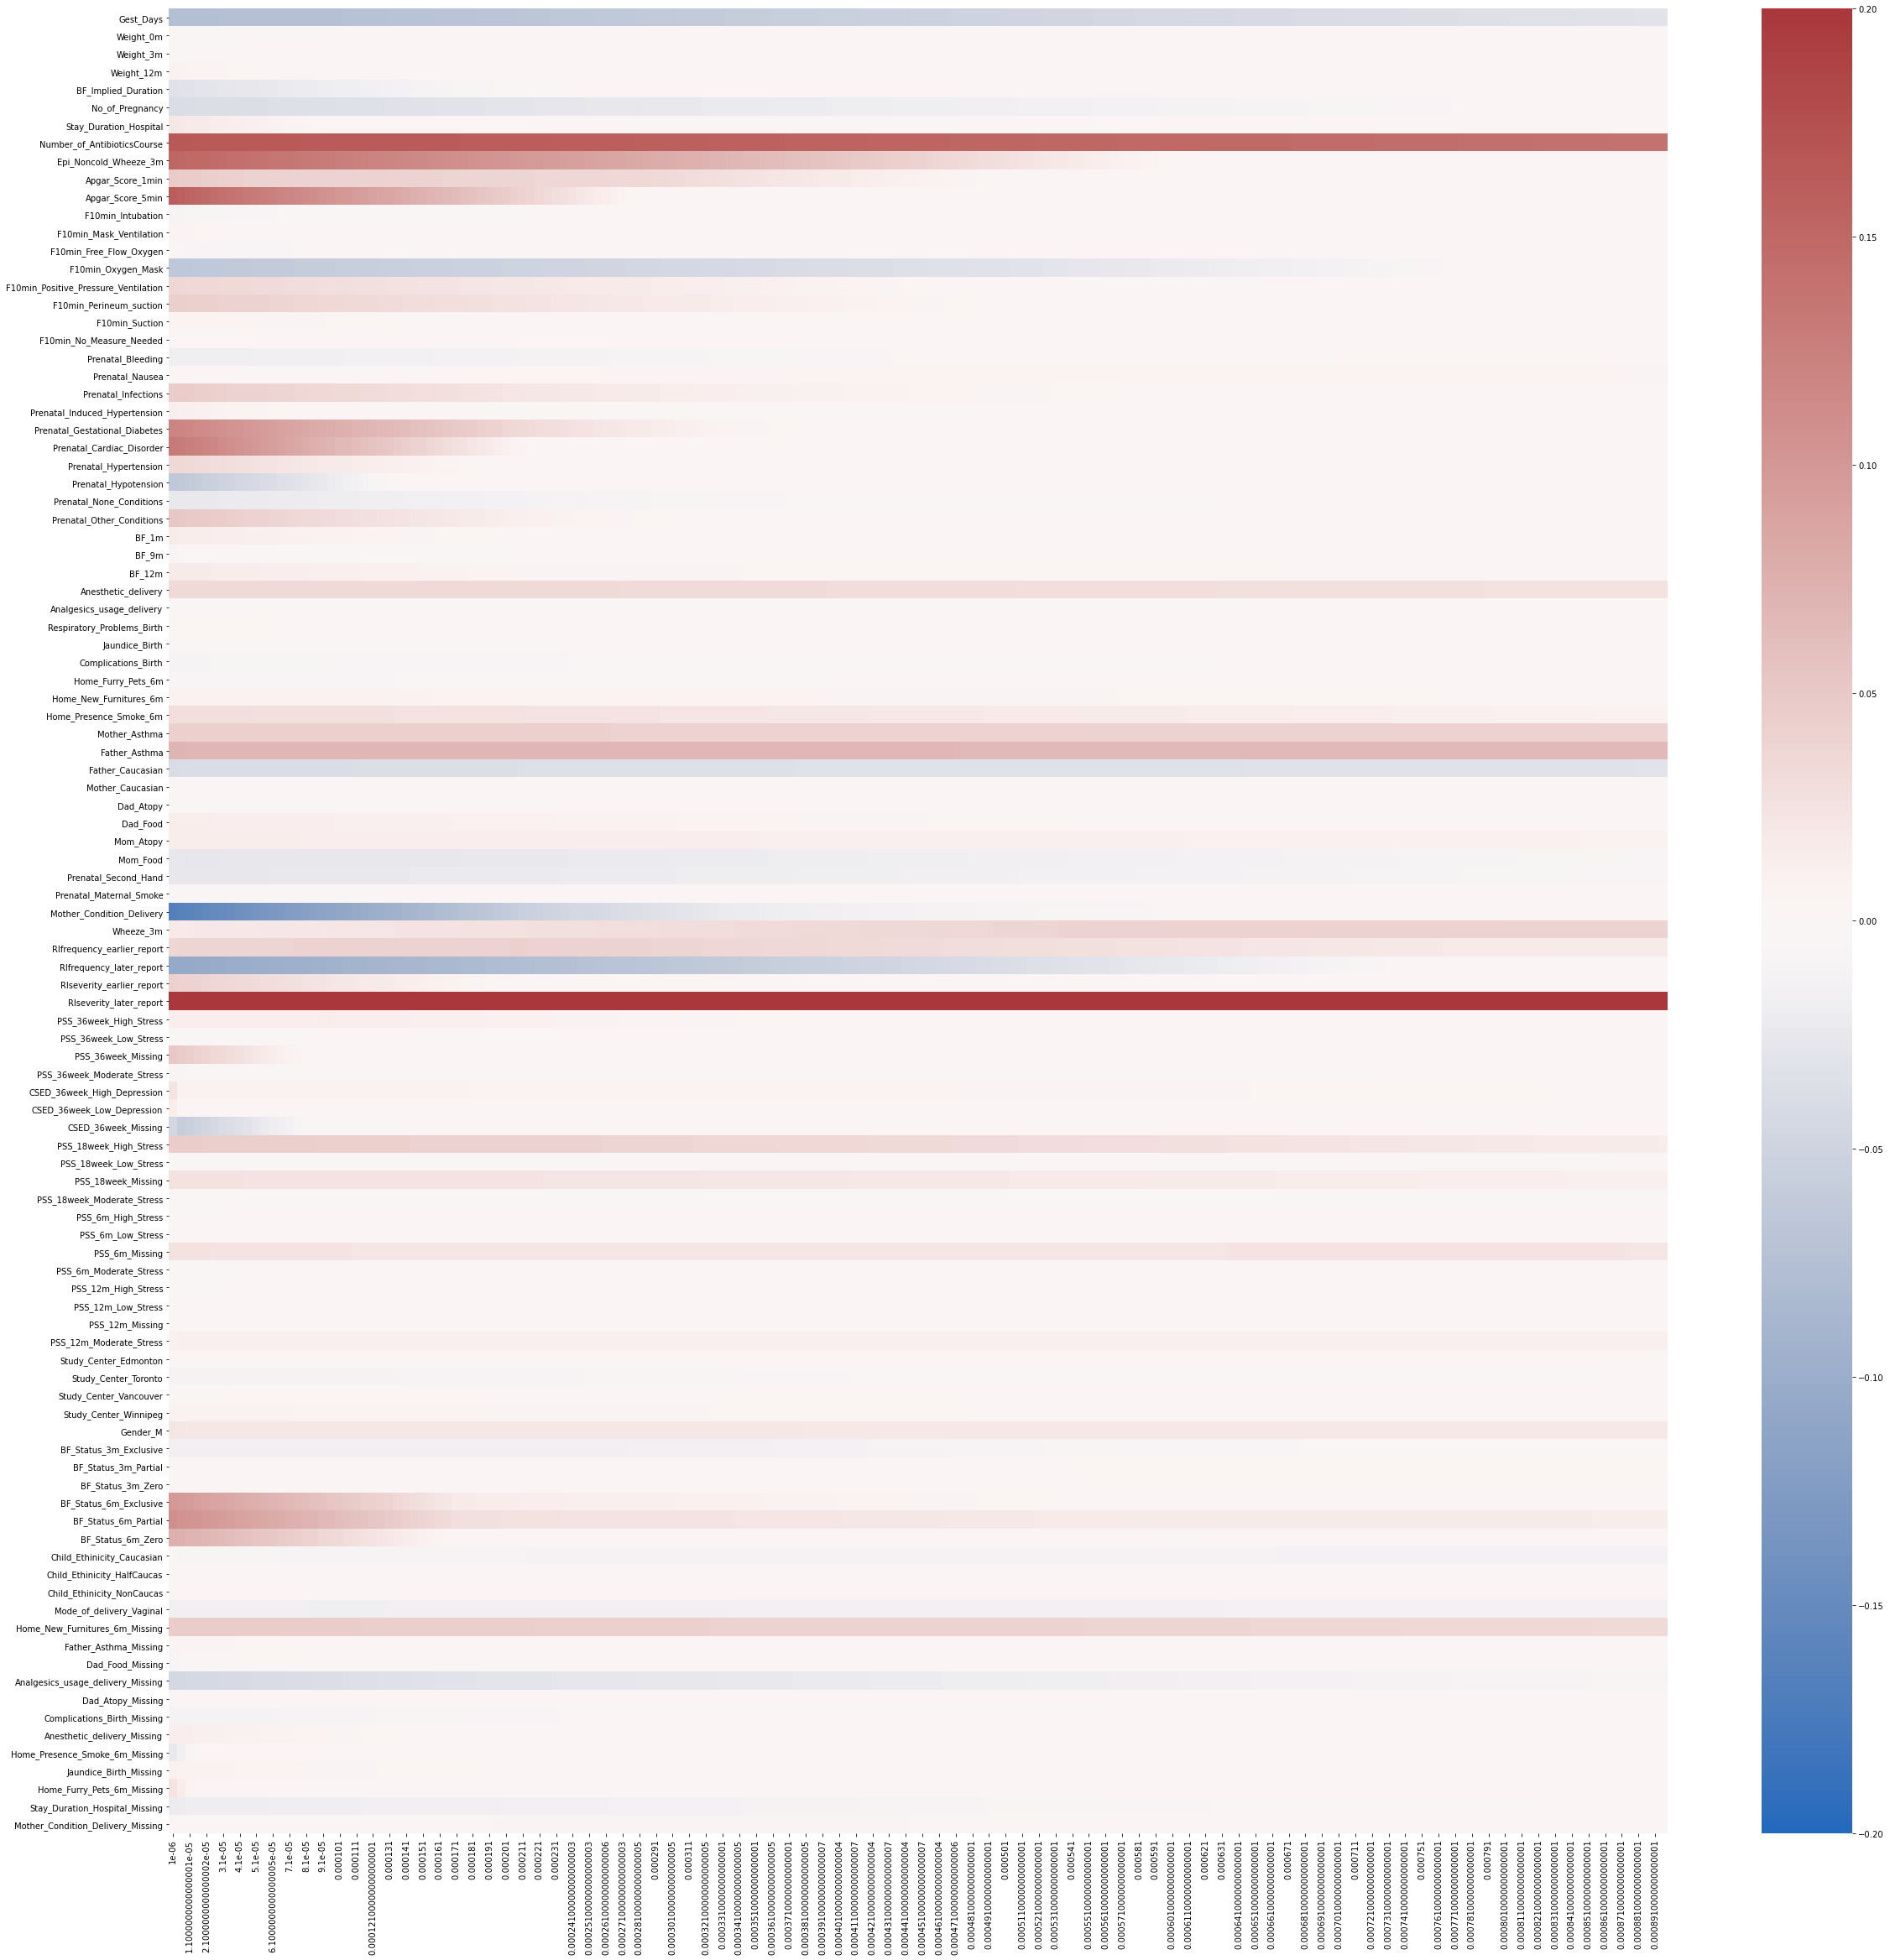

<IPython.core.display.Javascript object>

In [497]:
# sns.color_palette("YlOrBr", as_cmap=True)
fig, ax = plt.subplots(figsize=(40, 40))
sns.heatmap(res.iloc[:, :], vmax=0.2, vmin=-0.2, cmap="vlag", ax=ax)

#### (2) Chi2 & SelectPercentile

In [590]:
clf = Pipeline([("chi2", SelectPercentile(chi2)), ("rfc", RandomForestClassifier())])

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1020)

<IPython.core.display.Javascript object>

  0%|          | 0/11 [00:00<?, ?it/s]

Pipeline(steps=[('chi2',
                 SelectPercentile(percentile=1,
                                  score_func=<function chi2 at 0x7fc201e34430>)),
                ('rfc', RandomForestClassifier())])

Pipeline(steps=[('chi2',
                 SelectPercentile(percentile=5,
                                  score_func=<function chi2 at 0x7fc201e34430>)),
                ('rfc', RandomForestClassifier())])

Pipeline(steps=[('chi2',
                 SelectPercentile(score_func=<function chi2 at 0x7fc201e34430>)),
                ('rfc', RandomForestClassifier())])

Pipeline(steps=[('chi2',
                 SelectPercentile(percentile=15,
                                  score_func=<function chi2 at 0x7fc201e34430>)),
                ('rfc', RandomForestClassifier())])

Pipeline(steps=[('chi2',
                 SelectPercentile(percentile=20,
                                  score_func=<function chi2 at 0x7fc201e34430>)),
                ('rfc', RandomForestClassifier())])

Pipeline(steps=[('chi2',
                 SelectPercentile(percentile=30,
                                  score_func=<function chi2 at 0x7fc201e34430>)),
                ('rfc', RandomForestClassifier())])

Pipeline(steps=[('chi2',
                 SelectPercentile(percentile=40,
                                  score_func=<function chi2 at 0x7fc201e34430>)),
                ('rfc', RandomForestClassifier())])

Pipeline(steps=[('chi2',
                 SelectPercentile(percentile=60,
                                  score_func=<function chi2 at 0x7fc201e34430>)),
                ('rfc', RandomForestClassifier())])

Pipeline(steps=[('chi2',
                 SelectPercentile(percentile=80,
                                  score_func=<function chi2 at 0x7fc201e34430>)),
                ('rfc', RandomForestClassifier())])

Pipeline(steps=[('chi2',
                 SelectPercentile(percentile=90,
                                  score_func=<function chi2 at 0x7fc201e34430>)),
                ('rfc', RandomForestClassifier())])

Pipeline(steps=[('chi2',
                 SelectPercentile(percentile=100,
                                  score_func=<function chi2 at 0x7fc201e34430>)),
                ('rfc', RandomForestClassifier())])

<Figure size 864x576 with 0 Axes>

<ErrorbarContainer object of 3 artists>

Text(0.5, 1.0, 'Performance of the RandomForest-Chi2 varying the percentile of features selected')

([<matplotlib.axis.XTick at 0x7fc1d0f4d130>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0.5, 0, 'Percentile')

Text(0, 0.5, 'Precision Score')

(-3.95, 104.95, -0.19842652651702575, 1.1293909327881766)

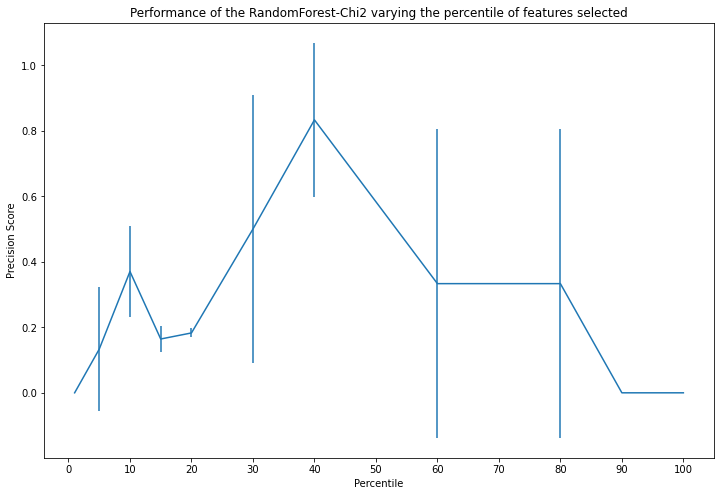

<IPython.core.display.Javascript object>

In [591]:
# #############################################################################
# Plot the cross-validation score as a function of percentile of features
score_means = list()
score_stds = list()
percentiles = (1, 5, 10, 15, 20, 30, 40, 60, 80, 90, 100)

for percentile in tqdm(percentiles):
    clf.set_params(chi2__percentile=percentile)
    this_scores = cross_val_score(clf, X, y, cv=skf, scoring="precision")
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())


plt.figure(figsize=(12, 8))
plt.errorbar(percentiles, score_means, np.array(score_stds))
plt.title(
    "Performance of the RandomForest-Chi2 varying the percentile of features selected"
)
plt.xticks(np.linspace(0, 100, 11, endpoint=True))
plt.xlabel("Percentile")
plt.ylabel("Precision Score")
plt.axis("tight")
plt.show()

In [541]:
chi_perc = SelectPercentile(chi2, percentile=30)
chi_perc.fit_transform(X, y)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float16)

<IPython.core.display.Javascript object>

In [542]:
# X.columns[chi_perc.get_support()]
chi_perc.get_feature_names_out()

X.columns
chi_perc.pvalues_
chi_perc.scores_

chi2_res = pd.DataFrame(
    [list(chi_perc.pvalues_), list(chi_perc.scores_)],
    index=["P_value", "Scores"],
    columns=X.columns,
).T

chi2_res[chi2_res.P_value < 0.05]

array(['Number_of_AntibioticsCourse', 'Epi_Noncold_Wheeze_3m',
       'F10min_Oxygen_Mask', 'Home_Furry_Pets_6m', 'Mother_Asthma',
       'Father_Asthma', 'Father_Caucasian', 'Mother_Caucasian',
       'Dad_Food', 'Wheeze_3m', 'RIfrequency_earlier_report',
       'RIfrequency_later_report', 'RIseverity_earlier_report',
       'RIseverity_later_report', 'PSS_36week_High_Stress',
       'CSED_36week_High_Depression', 'PSS_18week_High_Stress',
       'PSS_18week_Low_Stress', 'PSS_6m_Low_Stress', 'PSS_6m_Missing',
       'PSS_12m_Low_Stress', 'PSS_12m_Moderate_Stress', 'Gender_M',
       'BF_Status_3m_Partial', 'Child_Ethinicity_Caucasian',
       'Child_Ethinicity_HalfCaucas', 'Child_Ethinicity_NonCaucas',
       'Home_New_Furnitures_6m_Missing',
       'Analgesics_usage_delivery_Missing',
       'Home_Presence_Smoke_6m_Missing', 'Home_Furry_Pets_6m_Missing'],
      dtype=object)

Index(['Gest_Days', 'Weight_0m', 'Weight_3m', 'Weight_12m',
       'BF_Implied_Duration', 'No_of_Pregnancy', 'Stay_Duration_Hospital',
       'Number_of_AntibioticsCourse', 'Epi_Noncold_Wheeze_3m',
       'Apgar_Score_1min',
       ...
       'Dad_Food_Missing', 'Analgesics_usage_delivery_Missing',
       'Dad_Atopy_Missing', 'Complications_Birth_Missing',
       'Anesthetic_delivery_Missing', 'Home_Presence_Smoke_6m_Missing',
       'Jaundice_Birth_Missing', 'Home_Furry_Pets_6m_Missing',
       'Stay_Duration_Hospital_Missing', 'Mother_Condition_Delivery_Missing'],
      dtype='object', length=102)

array([5.96090975e-01, 7.88780459e-01, 8.91142953e-01, 7.80969607e-01,
       8.80250202e-01, 7.05808968e-01, 6.66718801e-01, 2.26982794e-04,
       1.95180019e-02, 9.29222235e-01, 9.54252516e-01, 4.54426375e-01,
       6.99204714e-01, 9.68691588e-01, 1.96489270e-01, 4.74825967e-01,
       2.98813613e-01, 8.61454793e-01, 9.48973206e-01, 9.20580528e-01,
       4.63746512e-01, 4.57738266e-01, 6.02607685e-01, 4.99784604e-01,
       6.03418766e-01, 9.79500826e-01, 5.90133778e-01, 3.74259387e-01,
       3.74147506e-01, 8.91820962e-01, 9.64162525e-01, 8.75194271e-01,
       2.54269652e-01, 8.82968573e-01, 3.88386073e-01, 4.58716432e-01,
       8.47790104e-01, 1.04704124e-01, 5.75744479e-01, 6.17531877e-01,
       7.93300544e-05, 1.37267719e-05, 9.84868545e-02, 1.81895688e-01,
       6.45525490e-01, 1.86699768e-01, 2.30011684e-01, 5.84760788e-01,
       4.84246525e-01, 8.11527892e-01, 6.62974735e-01, 1.92474360e-04,
       1.51132006e-01, 4.24179985e-02, 2.05906163e-01, 1.28189344e-02,
      

array([2.80932039e-01, 7.17675106e-02, 1.87301413e-02, 7.73149681e-02,
       2.26960393e-02, 1.42499235e-01, 1.85464254e-01, 1.35933946e+01,
       5.45449884e+00, 7.88960217e-03, 3.29102072e-03, 5.59587793e-01,
       1.49300510e-01, 1.54051150e-03, 1.66827853e+00, 5.10723173e-01,
       1.07948134e+00, 3.04581281e-02, 4.09552107e-03, 9.94058549e-03,
       5.36837067e-01, 5.51419501e-01, 2.71080797e-01, 4.55393775e-01,
       2.69870335e-01, 6.60219213e-04, 2.90135397e-01, 7.89473462e-01,
       7.89843320e-01, 1.84961098e-02, 2.01877027e-03, 2.46691551e-02,
       1.29969112e+00, 2.16699240e-02, 7.43988921e-01, 5.49024806e-01,
       3.68405230e-02, 2.63238809e+00, 3.13164999e-01, 2.49351783e-01,
       1.55741916e+01, 1.89067277e+01, 2.72987725e+00, 1.78206722e+00,
       2.11588119e-01, 1.74346989e+00, 1.44078913e+00, 2.98601020e-01,
       4.89284772e-01, 5.68609849e-02, 1.89930180e-01, 1.39031623e+01,
       2.06078792e+00, 4.11844708e+00, 1.59997917e+00, 6.19392804e+00,
      

,P_value,Scores
Number_of_AntibioticsCourse,0.000227,13.593395
Epi_Noncold_Wheeze_3m,0.019518,5.454499
Mother_Asthma,0.000079,15.574192
Father_Asthma,0.000014,18.906728
Wheeze_3m,0.000192,13.903162
RIfrequency_later_report,0.042418,4.118447
RIseverity_later_report,0.012819,6.193928
PSS_18week_High_Stress,0.041555,4.153235
PSS_6m_Missing,0.000193,13.897915
Gender_M,0.044303,4.044969


<IPython.core.display.Javascript object>

In [526]:
view_y_proportions(df_ml_scaled, chi2_res[chi2_res.P_value < 0.05].index, 0)

The proportion of definite asthma outcome for general cohorts is 6.76%


,Asthma_Proportion_over_thresh,Asthma_Outcome_over_thresh,Total_Number_over_thresh,Thresh
Epi_Noncold_Wheeze_3m,14.00,14.0,100.0,0.0
PSS_18week_High_Stress,14.00,7.0,50.0,0.0
Wheeze_3m,13.69,23.0,168.0,0.0
Home_New_Furnitures_6m_Missing,12.76,31.0,243.0,0.0
Home_Furry_Pets_6m_Missing,12.76,31.0,243.0,0.0
PSS_6m_Missing,12.65,32.0,253.0,0.0
Number_of_AntibioticsCourse,12.63,48.0,380.0,0.0
Father_Asthma,12.61,44.0,349.0,0.0
Home_Presence_Smoke_6m_Missing,12.60,31.0,246.0,0.0
Mother_Asthma,11.40,52.0,456.0,0.0


<IPython.core.display.Javascript object>

In [529]:
df_for_ml[df_for_ml.Home_Furry_Pets_6m_Missing != 0].y.value_counts(normalize=True)

0.0    0.872428
1.0    0.127572
Name: y, dtype: float64

<IPython.core.display.Javascript object>

#### (2) RFE - Observation

#### (2) RFE - Observation

#### (2) RFE - Observation

#### (3) Chi2 - Percentile

In [17]:
X = df_for_ml.drop(columns="y")
y = df_for_ml.y
X.shape
y.shape

(2218, 102)

(2218,)

<IPython.core.display.Javascript object>

In [ ]:
df_for_ml[df_for_ml.F10min_Suction == 1].y.value_counts(normalize=True)

In [ ]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt

mic = mutual_info_classif(X, y)
fig, ax = plt.subplots(figsize=(10, 20))
mic_df = (
    pd.DataFrame({"feature": X.columns, "vimp": mic})
    .set_index("feature")
    .sort_values(by="vimp", ascending=True)
)
mic_df[mic_df.vimp > 0].shape[0]
mic_df[mic_df.vimp > 0].plot.barh(ax=ax)
mic_df[mic_df.vimp == 0].index.values

### ML Pipeline Test Run